<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/openaifunction_constructing_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain neo4j openai wikipedia tiktoken

# Constructing knowledge graphs from text using OpenAI functions
## Seamlessy implement information extraction pipeline with LangChain and Neo4j
Extracting structured information from unstructured data like text has been around for some time and is nothing new. However, LLMs brought a significant shift to the field of information extraction. If before you needed a team of machine learning experts to curate datasets and train custom models, you only need access to an LLM nowadays. The barrier to entry has dropped significantly, making what was just a couple of years ago reserved for domain experts more accessible to even non-technical people.

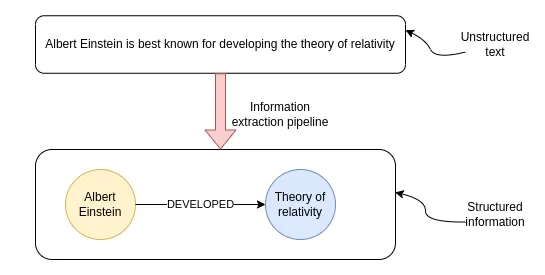

The image depicts the transformation of unstructured text into structured information. This process, labeled as the information extraction pipeline, results in a graph representation of information. The nodes represent key entities, while the connecting lines denote the relationships between these entities. Knowledge graphs are useful for [multi-hop question-answering](https://medium.com/neo4j/knowledge-graphs-llms-multi-hop-question-answering-322113f53f51), [real-time analytics](https://medium.com/neo4j/knowledge-graphs-llms-real-time-graph-analytics-89b392eaaa95), or when you want to [combine structured and unstructured data in a single database](https://blog.langchain.dev/using-a-knowledge-graph-to-implement-a-devops-rag-application/).

While extracting structured information from text has been made more accessible due to LLMs, it is by no means a solved problem. In this blog post, we will use OpenAI functions in combination with LangChain to construct a knowledge graph from a sample Wikipedia page. Along the way, we will discuss best practices as well as some limitations of current LLMs.

# Neo4j Environment setup
You need to setup a Neo4j to follow along with the examples in this blog post. The easiest way is to start a free instance on Neo4j Aura, which offers cloud instances of Neo4j database. Alternatively, you can also setup a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance.

The following code will instantiate a LangChain wrapper to connect to Neo4j Database.

In [1]:
from langchain.graphs import Neo4jGraph

url = "bolt://localhost:7687"
username ="neo4j"
password = "password"
graph = Neo4jGraph(
    url=url,
    username=username,
    password=password
)

## Information extraction pipeline
A typical information extraction pipeline contains the following steps.

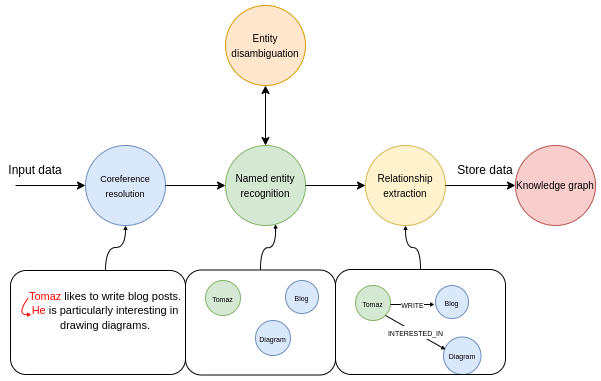

In the first step, we run the input text through a coreference resolution model. The coreference resolution is the task of finding all expressions that refer to a specific entity. Simply put, it links all the pronouns to the referred entity. In the named entity recognition part of the pipeline, we try to extract all the mentioned entities. The above example contains three entities: Tomaz, Blog, and Diagram. The next step is the entity disambiguation step, an essential but often overlooked part of an information extraction pipeline. Entity disambiguation is the process of accurately identifying and distinguishing between entities with similar names or references to ensure the correct entity is recognized in a given context. In the last step, the model tried to identify various relationships between entities. For example, it could locate the LIKES relationship between Tomaz and Blog entities.
## Extracting structured information with OpenAI functions
OpenAI functions are a great fit to extract structured information from natural language. The idea behind OpenAI functions is to have an LLM output a predefined JSON object with populated values. The predefined JSON object can be used as input to other functions in so-called RAG applications, or it can be used to extract predefined structured information from text.

In LangChain, you can pass a Pydantic class as description of the desired JSON object of the OpenAI functions feature. Therefore, we will start by defining the desired structure of information we want to extract from text. LangChain already has definitions of nodes and relationship as Pydantic classes that we can reuse.

Unfortunately, it turns out that OpenAI functions don't currently support a dictionary object as a value. Therefore, we have to overwrite the properties definition to adhere to the limitations of the functions' endpoint.

In [2]:
from langchain.graphs.graph_document import (
    Node as BaseNode,
    Relationship as BaseRelationship,
    GraphDocument,
)
from langchain.schema import Document
from typing import List, Dict, Any, Optional
from langchain.pydantic_v1 import Field, BaseModel

class Property(BaseModel):
  """A single property consisting of key and value"""
  key: str = Field(..., description="key")
  value: str = Field(..., description="value")

class Node(BaseNode):
    properties: Optional[List[Property]] = Field(
        None, description="List of node properties")

class Relationship(BaseRelationship):
    properties: Optional[List[Property]] = Field(
        None, description="List of relationship properties"
    )

class KnowledgeGraph(BaseModel):
    """Generate a knowledge graph with entities and relationships."""
    nodes: List[Node] = Field(
        ..., description="List of nodes in the knowledge graph")
    rels: List[Relationship] = Field(
        ..., description="List of relationships in the knowledge graph"
    )

Here, we have overwritten the properties value to be a list of Property classes instead of a dictionary to overcome the limitations of the API. Because you can only pass a single object to the API, we can to combine the nodes and relationships in a single class called KnowledgeGraph.

In [3]:
def format_property_key(s: str) -> str:
    words = s.split()
    if not words:
        return s
    first_word = words[0].lower()
    capitalized_words = [word.capitalize() for word in words[1:]]
    return "".join([first_word] + capitalized_words)

def props_to_dict(props) -> dict:
    """Convert properties to a dictionary."""
    properties = {}
    if not props:
      return properties
    for p in props:
        properties[format_property_key(p.key)] = p.value
    return properties

def map_to_base_node(node: Node) -> BaseNode:
    """Map the KnowledgeGraph Node to the base Node."""
    properties = props_to_dict(node.properties) if node.properties else {}
    # Add name property for better Cypher statement generation
    properties["name"] = node.id.title()
    return BaseNode(
        id=node.id.title(), type=node.type.capitalize(), properties=properties
    )

def map_to_base_relationship(rel: Relationship) -> BaseRelationship:
    """Map the KnowledgeGraph Relationship to the base Relationship."""
    source = map_to_base_node(rel.source)
    target = map_to_base_node(rel.target)
    properties = props_to_dict(rel.properties) if rel.properties else {}
    return BaseRelationship(
        source=source, target=target, type=rel.type, properties=properties
    )

The only thing left is to do a bit of prompt engineering and we are good to go. How I usually go about prompt engineering is the following:
* Iterate over prompt and improve results using natural language
* If something doesn't work as intended, ask ChatGPT to make it clearer for an LLM to understand the task
* Finally, when the prompt has all the instructions needed, ask ChatGPT to summarize the instructions in a markdown format, saving on tokens and perhaps having more clear instructions

I specifically chose the markdown format as I have seen somewhere that OpenAI models respond better to markdown syntax in prompts, and it seems to be at least plausible from my experience.
Iterating over prompt engineering, I came up with the following system prompt for an information extraction pipeline.

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [144]:
from langchain.chains.openai_functions import (
    create_openai_fn_chain,
    create_structured_output_chain,
)
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
llm = ChatOpenAI(model="gpt-3.5-turbo-16k", temperature=0)

def get_extraction_chain(
    allowed_nodes: Optional[List[str]] = None,
    allowed_rels: Optional[List[str]] = None
    ):
    prompt = ChatPromptTemplate.from_messages(
        [(
          "system",
          f"""# Knowledge Graph Instructions for GPT-4
## 1. Overview
You are a top-tier algorithm designed for extracting information in structured formats to build a knowledge graph.
- **Nodes** represent entities and concepts. They're akin to Wikipedia nodes.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.
## 2. Labeling Nodes
- **Consistency**: Ensure you use basic or elementary types for node labels.
  - For example, when you identify an entity representing a person, always label it as **"person"**. Avoid using more specific terms like "mathematician" or "scientist".
- **Node IDs**: Never utilize integers as node IDs. Node IDs should be names or human-readable identifiers found in the text.
{'- **Allowed Node Labels:**' + ", ".join(allowed_nodes) if allowed_nodes else ""}
{'- **Allowed Relationship Types**:' + ", ".join(allowed_rels) if allowed_rels else ""}
## 3. Handling Numerical Data and Dates
- Numerical data, like age or other related information, should be incorporated as attributes or properties of the respective nodes.
- **No Separate Nodes for Dates/Numbers**: Do not create separate nodes for dates or numerical values. Always attach them as attributes or properties of nodes.
- **Property Format**: Properties must be in a key-value format.
- **Quotation Marks**: Never use escaped single or double quotes within property values.
- **Naming Convention**: Use camelCase for property keys, e.g., `birthDate`.
## 4. Coreference Resolution
- **Maintain Entity Consistency**: When extracting entities, it's vital to ensure consistency.
If an entity, such as "John Doe", is mentioned multiple times in the text but is referred to by different names or pronouns (e.g., "Joe", "he"),
always use the most complete identifier for that entity throughout the knowledge graph. In this example, use "John Doe" as the entity ID.
Remember, the knowledge graph should be coherent and easily understandable, so maintaining consistency in entity references is crucial.
## 5. Strict Compliance
Adhere to the rules strictly. Non-compliance will result in termination.
          """),
            ("human", "Use the given format to extract information from the following input: {input}"),
            ("human", "Tip: Make sure to answer in the correct format"),
        ])
    return create_structured_output_chain(KnowledgeGraph, llm, prompt, verbose=False)

You can see that we are using the 16k version of the GPT-3.5 model. The main reason is that the OpenAI function output is a structured JSON object, and structured JSON syntax adds a lot of token overhead to the result. Essentially, you are paying for the convenience of structured output in increased token space.

Besides the general instructions, I have also added the option to limit which node or relationship types should be extracted from text. You'll see through examples why this might come in handy.
We have the Neo4j connection and LLM prompt ready, which means we can define the information extraction pipeline as a single function.

In [7]:
def extract_and_store_graph(
    document: Document,
    nodes:Optional[List[str]] = None,
    rels:Optional[List[str]]=None) -> None:
    # Extract graph data using OpenAI functions
    extract_chain = get_extraction_chain(nodes, rels)
    data = extract_chain.run(document.page_content)
    # Construct a graph document
    graph_document = GraphDocument(
      nodes = [map_to_base_node(node) for node in data.nodes],
      relationships = [map_to_base_relationship(rel) for rel in data.rels],
      source = document
    )
    # Store information into a graph
    graph.add_graph_documents([graph_document])

The function takes in a LangChain document as well as optional nodes and relationship parameters, which are used to limit the types of objects we want the LLM to identify and extract. A month or so ago, we added the add_graph_documents method the Neo4j graph object, which we can utilize here to seamlessly import the graph.
## Loading and Chunking
We will extract information from the Walt Disney Wikipedia page and construct a knowledge graph to test the pipeline. Here, we will utilize the Wikipedia loader and text chunking modules provided by LangChain.

### Wikipedia Loader

In [146]:
from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import TokenTextSplitter

# Read the wikipedia article
raw_documents = WikipediaLoader(query="Walt Disney").load()
# Define chunking strategy
text_splitter = TokenTextSplitter(chunk_size=2048, chunk_overlap=24)

# Only take the first the raw_documents
documents = text_splitter.split_documents(raw_documents[2:10])

In [158]:
# Only take the first the raw_documents
documents = text_splitter.split_documents(raw_documents[12:15])

In [142]:
documents[9]

Document(page_content='Walt Disney Records is an American record label of the Disney Music Group. The label releases soundtrack albums from The Walt Disney Company\'s motion picture studios, television series, theme parks, and traditional studio albums produced by its roster of pop, teen pop, and country artists.The label was founded on February 4, 1956 as Disneyland Records. Before that time, Disney recordings were licensed to a variety of other labels such as RCA, Decca, Capitol, ABC-Paramount, and United Artists. It was Disney Legend Jimmy Johnson who convinced Walt Disney’s brother Roy O. Disney that Walt Disney Productions (now The Walt Disney Company) should form their own record label. It adopted its current name in 1988 and is currently distributed by Universal Music Group for physical releases outside of North America and digital releases globally.\n\n\n== History ==\nDisneyland Records was predicated by non-soundtrack audio material based on Davy Crockett miniseries from the 

### Unstructured PDF Loader

To load data from pdf files "unstructured" is utilized. 

In [31]:
from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import elements_to_json

filename = "pdf/DIA_Dino_Celi_druck.pdf"

# Extracts the elements from the PDF
elements = partition_pdf(
    filename=filename,
    languages="ger",

    # Unstructured Helpers
    strategy="hi_res",
    infer_table_structure=True,
    model_name="yolox"
)

The ocr_languages kwarg will be deprecated in a future version of unstructured. Please use languages instead.


In [32]:
elements

In [51]:
elements[-4].text

'gen: Quelle: DIN EN ISO 19650-1, Organisation von Daten zu Bauwerken - Informati- onsmanagement mit BIM Teil 1: Konzepte und Grundsätze (ISO/DIS 19650-1.2:2018); Englische Fassung prEN ISO 19650-1:2018 22 22 nun nn nn 27 4.1 Beispiel Webseiten-Liste .... 2 2. CC Eon 37 4.2 Beispiel Webseite... 2.2 Co no nn nn 38 4.3 Funktionen einer Webseite... 2.2 u nn 39 4.4 Bearbeiten einer Webseite... 2.2 ou nn 40 4.5 Bearbeitung der Eigenschaften . 2.22. Coon nn 4 4.6 Einstellungen einer Liste... 2. oo Coon 42 4.7 Beispiel Webpart. .. 2.2.2 Co non nn 43 4.8 Webseiteninhalte. . 2222 CC on 44 4.9 Navigation... oo 2 oo 45 4.10 Webseiteneinstellungen . 2:22 o nn 46 4.11 Homepage der VAMED-BIM-Wissensdatenbank . .. 2.2.22 222 49 4.12 VAMED-BIM-Glossar . 222220 o non 50 4.13 Startseite des VAMED BIM Wikis. 2.220. oo on 51 4.14 Übersicht Leitlinien . 2222 con 53 4.15 Kollaborationsbereich . . 2222 oo nn 54'

### Semantic Splitting

In [62]:
import PyPDF2
import io

pdf_path = 'pdf/DIA_Dino_Celi_druck.pdf'

with open(pdf_path, 'rb') as file:
    pdf_reader = PyPDF2.PdfReader(file)

    # Create a new PdfFileWriter object to store all pages
    pdf_writer = PyPDF2.PdfWriter()

    # Include all pages from the original PDF
    for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        pdf_writer.add_page(page)

    # Create a BytesIO object to store all pages
    output_pdf_stream = io.BytesIO()
    pdf_writer.write(output_pdf_stream)

    # Seek back to the beginning of the stream
    output_pdf_stream.seek(0)

    # Read the content of all pages into the "essay" variable
    essay = output_pdf_stream.read()

# Now, the variable "essay" contains the content of all pages as bytes

In [65]:
import fitz  # PyMuPDF
import re

# Assuming "essay" is a byte string containing the PDF content
# (using the previous code to create the "essay" variable)

# Create a PyMuPDF document from the PDF content
pdf_document = fitz.open("pdf", stream=essay)

# Initialize an empty string to store the extracted text
text_content = ""

# Iterate through each page and extract the text
for page_number in range(pdf_document.page_count):
    page = pdf_document[page_number]
    text_content += page.get_text()

# Splitting the text on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', text_content)

print(f"{len(single_sentences_list)} sentences were found")


3809 sentences were found


In [66]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': 'DIPLOMARBEIT\nVAMED BIM Wiki\nKonzept eines unternehmensweiten\nWissensmanagementsystems für das Building Information\nModeling\neingereicht an der\nFH JOANNEUM Gesellschaft mbH\nFachhochschulstudiengang\nBaumanagement und Ingenieurbau\nvorgelegt von:\nDino Maximilian Celi, BSc\n1810234003\nBetreuer:\nThomas Mathoi, Bmstr.',
  'index': 0},
 {'sentence': 'DI Dr.', 'index': 1},
 {'sentence': 'BMI 18\nGraz, 2020\nSeite II\nEhrenwörtliche Erklärung\nIch erkläre ehrenwörtlich, dass ich die vorliegende Diplomarbeit selbstständig angefertigt und\ndie mit ihr verbundenen Tätigkeiten selbst erbracht habe.',
  'index': 2}]

In [67]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [68]:
sentences[:3]

[{'sentence': 'DIPLOMARBEIT\nVAMED BIM Wiki\nKonzept eines unternehmensweiten\nWissensmanagementsystems für das Building Information\nModeling\neingereicht an der\nFH JOANNEUM Gesellschaft mbH\nFachhochschulstudiengang\nBaumanagement und Ingenieurbau\nvorgelegt von:\nDino Maximilian Celi, BSc\n1810234003\nBetreuer:\nThomas Mathoi, Bmstr.',
  'index': 0,
  'combined_sentence': 'DIPLOMARBEIT\nVAMED BIM Wiki\nKonzept eines unternehmensweiten\nWissensmanagementsystems für das Building Information\nModeling\neingereicht an der\nFH JOANNEUM Gesellschaft mbH\nFachhochschulstudiengang\nBaumanagement und Ingenieurbau\nvorgelegt von:\nDino Maximilian Celi, BSc\n1810234003\nBetreuer:\nThomas Mathoi, Bmstr. DI Dr.'},
 {'sentence': 'DI Dr.',
  'index': 1,
  'combined_sentence': 'DIPLOMARBEIT\nVAMED BIM Wiki\nKonzept eines unternehmensweiten\nWissensmanagementsystems für das Building Information\nModeling\neingereicht an der\nFH JOANNEUM Gesellschaft mbH\nFachhochschulstudiengang\nBaumanagement und 

In [69]:
from langchain.embeddings import OpenAIEmbeddings
oaiembeds = OpenAIEmbeddings()

In [70]:
embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])

In [71]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [73]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [74]:
distances, sentences = calculate_cosine_distances(sentences)

In [75]:
distances[:3]

[0.02763450856434746, 0.10935874345283114, 0.027295852436058032]

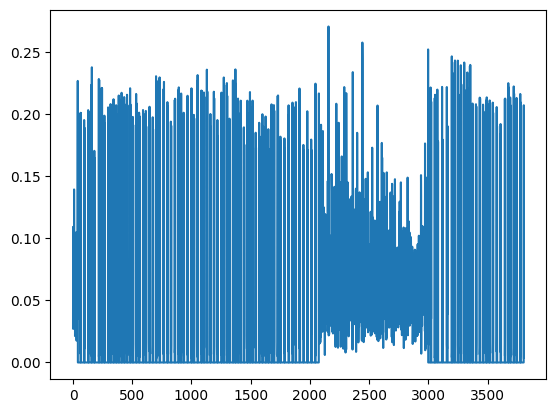

In [76]:
import matplotlib.pyplot as plt

plt.plot(distances);


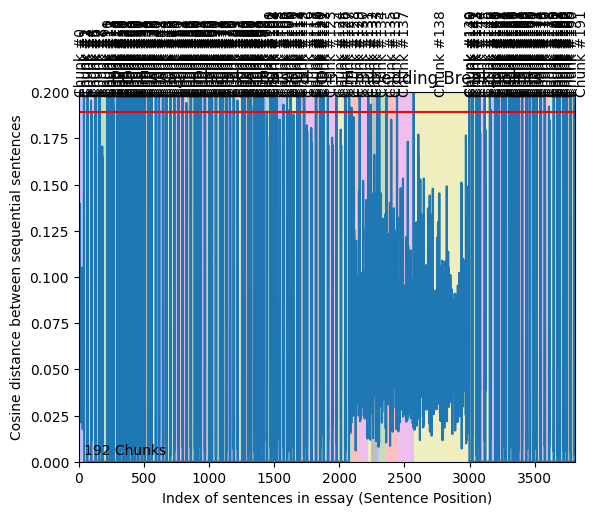

In [77]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

In [78]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [80]:
for i, chunk in enumerate(chunks[:10]):
    buffer = 200
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
DIPLOMARBEIT
VAMED BIM Wiki
Konzept eines unternehmensweiten
Wissensmanagementsystems für das Building Information
Modeling
eingereicht an der
FH JOANNEUM Gesellschaft mbH
Fachhochschulstudiengang
Bau
...
vice and activity descriptions, summarized under the term guidelines. Diplomarbeit Dino Celi
März 2020
Inhaltsverzeichnis
Seite VI
Inhaltsverzeichnis
1
Einleitung
1
1.1
Digitalisierung im Bauwesen . .


Chunk #1
. . . . . . . . . . . . . . . . . . . . . . . .
...
. . . . . . . . . . . . . . . . . . . . . . . .


Chunk #2
. 1
1.2
Forschungsmotivation . .
...
. 1
1.2
Forschungsmotivation . .


Chunk #3
. . . . . . . . . . . . . . . . . . . . . . . . . . .
...
. . . . . . . . . . . . . . . . . . . . . . . . . . .


Chunk #4
. 2
1.3
Ziel der Arbeit . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
...
. 2
1.3
Ziel der Arbeit . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


Chunk #5
. 2
1.4
Beschreibung des Aufbaus . .
...
. 2
1.4
Beschreibung de

### "Agentic" Chunking

https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/5_Levels_Of_Text_Splitting.ipynb

Example: Greg went to the park. He likes walking > ['Greg went to the park.', 'Greg likes walking']

In [82]:
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_community.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain.chains import create_extraction_chain
from typing import Optional, List
from langchain.chains import create_extraction_chain_pydantic
from langchain_core.pydantic_v1 import BaseModel
from langchain import hub

In [84]:
obj = hub.pull("wfh/proposal-indexing")
llm = ChatOpenAI(model="gpt-3.5-turbo-16k", temperature=0)

In [85]:
# use it in a runnable
runnable = obj | llm

In [87]:
# Pydantic data class
class Sentences(BaseModel):
    sentences: List[str]
    
# Extraction
extraction_chain = create_extraction_chain_pydantic(pydantic_schema=Sentences, llm=llm)

In [88]:
def get_propositions(text):
    runnable_output = runnable.invoke({
    	"input": text
    }).content
    
    propositions = extraction_chain.run(runnable_output)[0].sentences
    return propositions

In [92]:
import PyPDF2

pdf_path = 'pdf/2023_Annual_Report.pdf'

with open(pdf_path, 'rb') as file:
    pdf_reader = PyPDF2.PdfReader(file)

    # Initialize an empty string to store the extracted text
    text_content = ""

    # Extract text from each page and concatenate it to the text_content
    for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        text_content += page.extract_text()

# Now, the variable "text_content" contains the text of all pages
essay = text_content


In [95]:
text_content

'  \n \n1 Dear shareholders, colleagues, customers, and partners,  We are living through a time of historic challenge and opportunity. As I write this, the world faces ongoing economic, social, and geopolitical volatility. At the same time, we have entered a new age of AI that will fundamentally transform productivity for every individual, organization, and industry on earth, and help us address some of our most pressing challenges.  This next generation of AI will reshape every software category and every business, including our own. Forty-eight years after its founding, Microsoft remains a consequential company because time and time again—from PC/Server, to Web/Internet, to Cloud/Mobile—we have adapted to technological paradigm shifts. Today, we are doing so once again, as we lead this new era.  Amid this transformation, our mission to empower every person and every organization on the planet to achieve more remains constant. As a company, we believe we can be the democratizing force

In [96]:
paragraphs = essay.split("\n")

In [97]:
len(paragraphs)

81

In [98]:
essay_propositions = []

for i, para in enumerate(paragraphs[5:]):
    propositions = get_propositions(para)
    
    essay_propositions.extend(propositions)
    print (f"Done with {i}")

Done with 0
Done with 1
Done with 2
Done with 3
Done with 4


In [101]:
print (f"You have {len(essay_propositions)} propositions")
essay_propositions[160:169]

You have 169 propositions


['LinkedIn has become mission critical to help more than 950 million members connect, learn, sell, and get hired.',
 'In gaming, the company is rapidly executing on its ambition to be the first choice for people to play games whenever, wherever, and however they want.',
 'Xbox Game Pass is redefining how games are distributed, played, and viewed.',
 'Content is the flywheel behind the service’s growth for Xbox Game Pass.',
 'The pipeline for Xbox Game Pass has never been stronger.',
 'Starfield was released this fall to broad acclaim.',
 'More than 10 million players played Starfield in the first month post-launch.',
 'The acquisition of Activision Blizzard by the company was closed earlier this month.',
 'The company looks forward to sharing more about how it will bring the joy of gaming to more people around the world with Activision Blizzard.']

In [103]:
# mini script I made
from agentic_chunker import AgenticChunker

In [105]:
ac = AgenticChunker()

In [106]:
ac.add_propositions(essay_propositions)


Adding: '[]'
No chunks, creating a new one
Created new chunk (6e838): Unspecified Activities

Adding: '[]'
No chunks found
Created new chunk (fdcbb): Unspecified Propositions

Adding: 'The letter is addressed to shareholders, colleagues, customers, and partners of the company.'
No chunks found
Created new chunk (7ce25): Recipients of Communication

Adding: 'The company is experiencing a time of historic challenge and opportunity.'
No chunks found
Created new chunk (1cb0e): Company Status & Conditions

Adding: 'The world is facing ongoing economic, social, and geopolitical volatility.'
No chunks found
Created new chunk (f503a): Global Challenges & Instabilities

Adding: 'A new age of AI has begun that will fundamentally transform productivity for every individual, organization, and industry on earth.'
No chunks found
Created new chunk (40c4d): AI Impact on Productivity

Adding: 'The new age of AI will help address some of the most pressing challenges.'
Chunk Found (f503a), adding to: G

In [110]:
ac.pretty_print_chunks()


You have 31 chunks

Chunk #0
Chunk ID: 6e838
Summary: This chunk will contain information about the actions or activities that are not specified or provided.
Propositions:
    -[]



Chunk #1
Chunk ID: fdcbb
Summary: This chunk will contain information about unspecified or missing propositions.
Propositions:
    -[]



Chunk #2
Chunk ID: 7ce25
Summary: This chunk contains information about the recipients of a company's letter.
Propositions:
    -The letter is addressed to shareholders, colleagues, customers, and partners of the company.



Chunk #3
Chunk ID: 1cb0e
Summary: This chunk discusses Microsoft's strategic direction, emphasizing its adaptation to technological shifts, AI leadership, cloud services, and commitment to empowering global progress through technology.
Propositions:
    -The company is experiencing a time of historic challenge and opportunity.
    -Microsoft is a company that remains consequential forty-eight years after its founding.
    -Microsoft has adapted to t

In [107]:
chunks = ac.get_chunks(get_type='list_of_strings')

In [108]:
chunks

['[]',
 '[]',
 'The letter is addressed to shareholders, colleagues, customers, and partners of the company.',
 "The company is experiencing a time of historic challenge and opportunity. Microsoft is a company that remains consequential forty-eight years after its founding. Microsoft has adapted to technological paradigm shifts, including PC/Server, Web/Internet, and Cloud/Mobile. Microsoft is leading the new era of AI. Microsoft's mission to empower every person and every organization on the planet to achieve more remains constant. Microsoft aims to be the democratizing force for this new generation of technology. Microsoft aims to help unlock opportunities for every country, community, and individual while mitigating risks. Microsoft has three convictions regarding its future progress. Microsoft will maintain its lead as the top commercial cloud. Microsoft will innovate in consumer categories, including gaming and professional social networks. Microsoft will invest to accelerate its 

In [129]:
from langchain.text_splitter import CharacterTextSplitter
text_splitter = CharacterTextSplitter()
documents = text_splitter.create_documents(chunks[2:])

In [130]:
documents

[Document(page_content='The letter is addressed to shareholders, colleagues, customers, and partners of the company.'),
 Document(page_content="The company is experiencing a time of historic challenge and opportunity. Microsoft is a company that remains consequential forty-eight years after its founding. Microsoft has adapted to technological paradigm shifts, including PC/Server, Web/Internet, and Cloud/Mobile. Microsoft is leading the new era of AI. Microsoft's mission to empower every person and every organization on the planet to achieve more remains constant. Microsoft aims to be the democratizing force for this new generation of technology. Microsoft aims to help unlock opportunities for every country, community, and individual while mitigating risks. Microsoft has three convictions regarding its future progress. Microsoft will maintain its lead as the top commercial cloud. Microsoft will innovate in consumer categories, including gaming and professional social networks. Microsoft

## Evaluation
You might have noticed that we use a relatively large chunk_size value. The reason is that we want to provide as much context as possible around a single sentence in order for the coreference resolution part to work as best as possible. Remember, the coreference step will only work if the entity and its reference appear in the same chunk; otherwise, the LLM doesn't have enough information to link the two.

Now we can go ahead and run the documents through the information extraction pipeline.

In [131]:
from tqdm import tqdm

for i, d in tqdm(enumerate(documents), total=len(documents)):
    extract_and_store_graph(d)

100%|██████████| 29/29 [13:35<00:00, 28.14s/it]


The process takes around 5 minutes, which is relatively slow. Therefore, you would probably want parallel API calls in production to deal with this problem and achieve some sort of scalability.
Let's first look at the types of nodes and relationships the LLM identified.

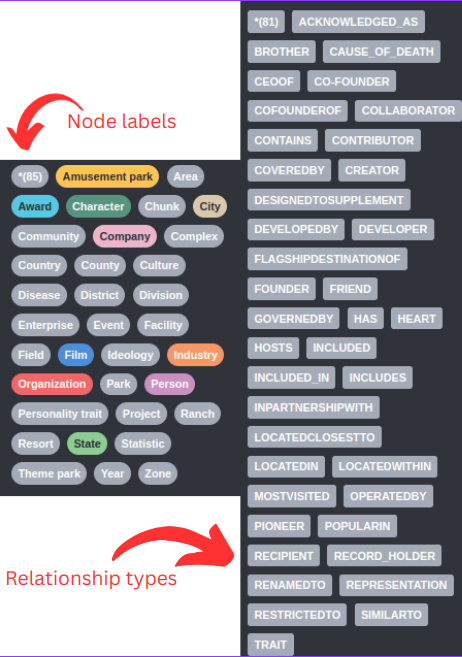

Since the graph schema is not provided, the LLM decides on the fly what types of node labels and relationship types it will use. For example, we can observe that there are Company and Organization node labels. Those two things are probably semantically similar or identical, so we would want to have only a single node label representing the two. This problem is more obvious with relationship types. For example, we have CO-FOUNDER and COFOUNDEROF relationships as well as DEVELOPER and DEVELOPEDBY.
For any more serious project, you should define the node labels and relationship types the LLM should extract. Luckily, we have added the option to limit the types in the prompt by passing additional parameters.

In [138]:
# Delete the graph
graph.query("MATCH (n) DETACH DELETE n")

[]

In [159]:
# Specify which node labels should be extracted by the LLM
allowed_nodes = ["Person", "Company", "Location", "Event", "Movie", "Service", "Award"]

for i, d in tqdm(enumerate(documents), total=len(documents)):
    extract_and_store_graph(d, allowed_nodes)

 67%|██████▋   | 2/3 [12:41<06:20, 380.98s/it]


KeyboardInterrupt: 

In this example, I have only limited the node labels, but you can easily limit the relationship types by passing another parameter to the `extract_and_store_graph` function.

The graph turned out better than expected (after five iterations :) ). I couldn't catch the whole graph nicely in the visualization, but you can explore it on your own in Neo4j Browser other tools.
## Entity disambiguation
One thing I should mention is that we partly skipped entity disambiguation part. We used a large chunk size and added a specific instruction for coreference resolution and entity disambiguation in the system prompt. However, since each chunk is processed separately, there is no way to ensure consistency of entities between different text chunks. For example, you could end up with two nodes representing the same person.

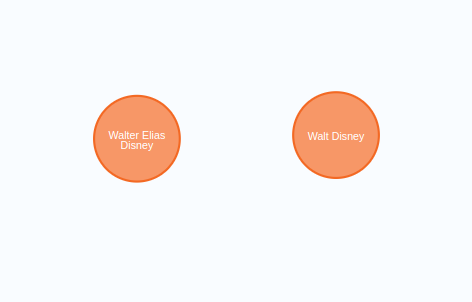

In this example, Walt Disney and Walter Elias Disney refer to the same real-world person. The entity disambiguation problem is nothing new and there has been various solution proposed to solve it:
* Using [entity linking](https://wikifier.org/about.html) or [entity disambiguation NLP models](https://github.com/SapienzaNLP/extend)
* Doing a [second pass through an LLM and asking it to perform entity disambiguation](https://medium.com/neo4j/creating-a-knowledge-graph-from-video-transcripts-with-gpt-4-52d7c7b9f32c)
* [Graph-based approaches](https://neo4j.com/developer-blog/exploring-supervised-entity-resolution-in-neo4j/)

Which solution you should use depends on your domain and use case. However, have in mind that entity disambiguation step should not be overlooked as it can have a significant impact on the accuracy and effectiveness of your RAG applications.
## Rag Application
The last thing we will do is show you how you can browse information in a knowledge graph by constructing Cypher statements. Cypher is a structured query language used to work with graph databases, similar to how SQL is used for relational databases. LangChain has a [GraphCypherQAChain](https://medium.com/neo4j/langchain-cypher-search-tips-tricks-f7c9e9abca4d) that reads the schema of the graph and constructs appropriate Cypher statements based on the user input.

In [149]:
# Query the knowledge graph in a RAG application
from langchain.chains import GraphCypherQAChain

graph.refresh_schema()

cypher_chain = GraphCypherQAChain.from_llm(
    graph=graph,
    cypher_llm=ChatOpenAI(temperature=0, model="gpt-4"),
    qa_llm=ChatOpenAI(temperature=0, model="gpt-3.5-turbo"),
    validate_cypher=True, # Validate relationship directions
    verbose=True
)

In [160]:
cypher_chain.run("When was Walter Elias Disney born?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {name: "Walter Elias Disney"}) RETURN p.birthdate
Full Context:
[{'p.birthdate': 'December 5, 1901'}]

> Finished chain.


'Walter Elias Disney was born on December 5, 1901.'

In [161]:
cypher_chain.run("List all Movies produced by Walter Elias Disney")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person {name: "Walter Elias Disney"})-[:PRODUCED]->(m:Movie) RETURN m.name
Full Context:
[{'m.name': 'Snow White And The Seven Dwarfs'}, {'m.name': 'Pinocchio'}, {'m.name': 'Fantasia'}, {'m.name': 'Dumbo'}, {'m.name': 'Bambi'}, {'m.name': 'Cinderella'}, {'m.name': 'Sleeping Beauty'}, {'m.name': 'Mary Poppins'}]

> Finished chain.


'The movies produced by Walter Elias Disney include Snow White And The Seven Dwarfs, Pinocchio, Fantasia, Dumbo, Bambi, Cinderella, Sleeping Beauty, and Mary Poppins.'

## Summary
Knowledge graphs are a great fit when you need a combination of structured and structured data to power your RAG applications. In this blog post, you have learned how to construct a knowledge graph in Neo4j on an arbitrary text using OpenAI functions. OpenAI functions provide the convenience of neatly structured outputs, making them an ideal fit for extracting structured information. Just make sure you add an entity disambiguation step after the extraction, and you are golden.